# Import Model Architectures

Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import torchvision
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cpu
Using device: cpu
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


# Loading the Model Weights

Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device('cpu')))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device('cpu')))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

# Square Attack

This attack manipulates square-shaped regions in the feature space to generate adversarial examples. The regions are chosen and updated on a schedule, and this attack takes in hyperparameters epsilon which is the lp-radius i.e. max perturbation size, and maximum iterations

Other black box attacks query models way more times with a success rate way lower than that of white box attacks. The benefit of the square attack is that it is query efficient.

In [6]:
def test_square(model, test_loader, mnist = 1, max_iterations=500):
    model.eval()

    pred_list = []
    correct = 0
    total = 0
    adv_examples = []
    if mnist:
        channels = 1
    else:
        channels = 3

    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)

            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)
            

            advimages = square_attack(model, image, size=image.shape[2], channels=channels, epsilon=0.3,label=label, mnist=mnist, max_iterations=max_iterations)
            output_adv, _ = model(advimages)
            
            
            _, prediction_adv = torch.max(output_adv.data, 1)

            if torch.equal(prediction_adv, label):
                correct += 1
            else:
                # Save some adv examples for visualization later
                adv_ex = advimages.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred, prediction_adv, adv_ex) )
                
                        
            total +=1 
            print(correct, "/", total)  
            
        
    accuracy = (float(correct) / total) * 100       
    print('Accuracy of test text: %f %%' % ((float(correct) / total) * 100))
    return accuracy, adv_examples

In [7]:
_, adv_examples = test_square(mnist_resnet_model, test_loader_mnist, mnist = 1)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


1 / 1
2 / 2
3 / 3
4 / 4
4 / 5
4 / 6
4 / 7
4 / 8
4 / 9
4 / 10
5 / 11
5 / 12
5 / 13
6 / 14
7 / 15
7 / 16
7 / 17
8 / 18
8 / 19
9 / 20
9 / 21
10 / 22
10 / 23
10 / 24
10 / 25
11 / 26
12 / 27
13 / 28
14 / 29
15 / 30
16 / 31
16 / 32
16 / 33
17 / 34
18 / 35
19 / 36
19 / 37
20 / 38
20 / 39
20 / 40
21 / 41
22 / 42
23 / 43
23 / 44
23 / 45
24 / 46
24 / 47
25 / 48
25 / 49
26 / 50
27 / 51
28 / 52
28 / 53
29 / 54
30 / 55
31 / 56
32 / 57
32 / 58
32 / 59
33 / 60
34 / 61
35 / 62
35 / 63
35 / 64
36 / 65
36 / 66
37 / 67
38 / 68
39 / 69
40 / 70
41 / 71
42 / 72
42 / 73
43 / 74
43 / 75
44 / 76
45 / 77
46 / 78
46 / 79
46 / 80
47 / 81
48 / 82
49 / 83
50 / 84
51 / 85
52 / 86
53 / 87
53 / 88
53 / 89
53 / 90
54 / 91
55 / 92
55 / 93
55 / 94
56 / 95
56 / 96
57 / 97
58 / 98
59 / 99
60 / 100
61 / 101
62 / 102
63 / 103
64 / 104
64 / 105
64 / 106
64 / 107
64 / 108
65 / 109
66 / 110
67 / 111
67 / 112
67 / 113
68 / 114
68 / 115
68 / 116
69 / 117
70 / 118
70 / 119
70 / 120
70 / 121
70 / 122
71 / 123
72 / 124
72 / 125
72 /

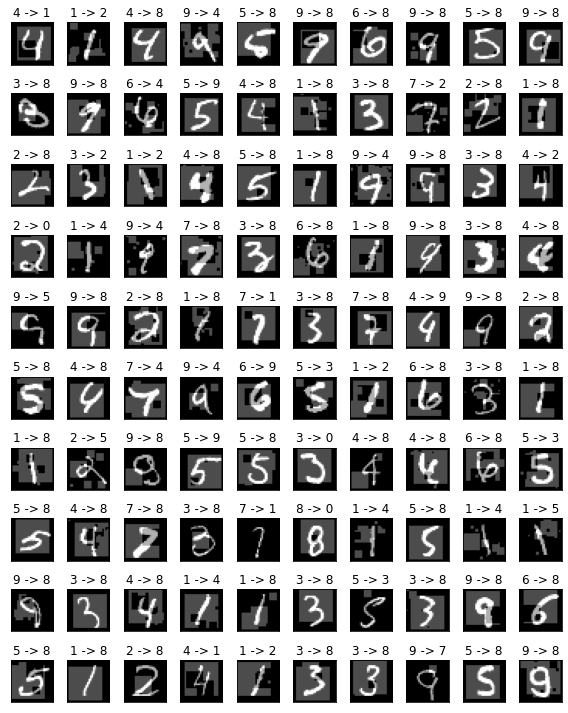

In [8]:
adv_examples = adv_examples[:100]
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [9]:
_, adv_examples = test_square(svhn_resnet_model, test_loader_svhn, mnist = 0)

0 / 1
1 / 2
1 / 3
1 / 4
1 / 5
2 / 6
2 / 7
2 / 8
2 / 9
3 / 10
3 / 11
3 / 12
3 / 13
3 / 14
3 / 15
4 / 16
5 / 17
5 / 18
6 / 19
7 / 20
8 / 21
9 / 22
10 / 23
10 / 24
11 / 25
12 / 26
13 / 27
13 / 28
14 / 29
14 / 30
14 / 31
15 / 32
15 / 33
15 / 34
15 / 35
16 / 36
16 / 37
17 / 38
17 / 39
18 / 40
18 / 41
19 / 42
19 / 43
19 / 44
19 / 45
19 / 46
20 / 47
21 / 48
21 / 49
22 / 50
23 / 51
24 / 52
25 / 53
25 / 54
25 / 55
25 / 56
25 / 57
25 / 58
25 / 59
25 / 60
26 / 61
26 / 62
26 / 63
27 / 64
27 / 65
27 / 66
28 / 67
28 / 68
29 / 69
29 / 70
29 / 71
29 / 72
29 / 73
30 / 74
31 / 75
31 / 76
31 / 77
31 / 78
32 / 79
33 / 80
34 / 81
34 / 82
35 / 83
35 / 84
35 / 85
36 / 86
36 / 87
36 / 88
36 / 89
37 / 90
37 / 91
38 / 92
38 / 93
38 / 94
38 / 95
39 / 96
39 / 97
40 / 98
40 / 99
41 / 100
42 / 101
43 / 102
44 / 103
45 / 104
45 / 105
46 / 106
47 / 107
47 / 108
48 / 109
49 / 110
49 / 111
50 / 112
50 / 113
50 / 114
50 / 115
51 / 116
52 / 117
52 / 118
52 / 119
53 / 120
54 / 121
54 / 122
55 / 123
56 / 124
56 / 125
57 / 

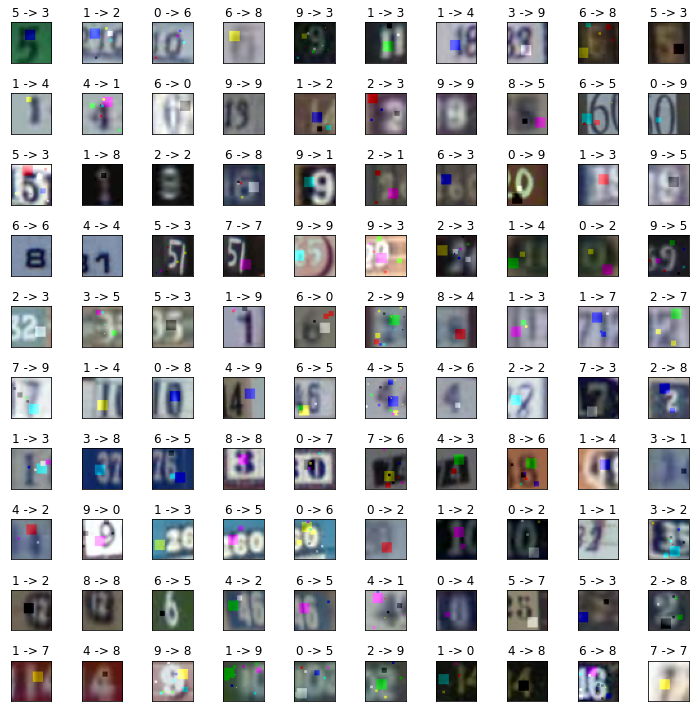

In [10]:
adv_examples = adv_examples[:100]
plt.figure(figsize=(10, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex # /255 # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()

In [11]:
_, adv_examples = test_square(cifar_resnet_model, test_loader_cifar10, mnist = 0)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
1 / 6
2 / 7
2 / 8
2 / 9
3 / 10
3 / 11
4 / 12
4 / 13
5 / 14
6 / 15
6 / 16
7 / 17
7 / 18
8 / 19
8 / 20
8 / 21
8 / 22
8 / 23
9 / 24
9 / 25
9 / 26
9 / 27
10 / 28
11 / 29
12 / 30
12 / 31
12 / 32
12 / 33
12 / 34
13 / 35
13 / 36
13 / 37
13 / 38
14 / 39
14 / 40
15 / 41
16 / 42
16 / 43
16 / 44
17 / 45
18 / 46
19 / 47
19 / 48
19 / 49
19 / 50
20 / 51
20 / 52
20 / 53
20 / 54
21 / 55
21 / 56
21 / 57
21 / 58
21 / 59
21 / 60
22 / 61
22 / 62
22 / 63
22 / 64
22 / 65
22 / 66
22 / 67
22 / 68
22 / 69
22 / 70
22 / 71
22 / 72
22 / 73
22 / 74
22 / 75
23 / 76
23 / 77
23 / 78
23 / 79
23 / 80
23 / 81
23 / 82
24 / 83
24 / 84
24 / 85
24 / 86
24 / 87
24 / 88
25 / 89
26 / 90
26 / 91
26 / 92
27 / 93
28 / 94
28 / 95
28 / 96
28 / 97
28 / 98
29 / 99
30 / 100
30 / 101
30 / 102
31 / 103
31 / 104
32 / 105
33 / 106
33 / 107
34 / 108
34 / 109
35 / 110
35 / 111
35 / 112
35 / 113
35 / 114
35 / 115
35 / 116
36 / 117
36 / 118
36 / 119
36 / 120
36 / 121
36 / 122
36 / 123
36 / 124
36 / 125
36 / 126
3

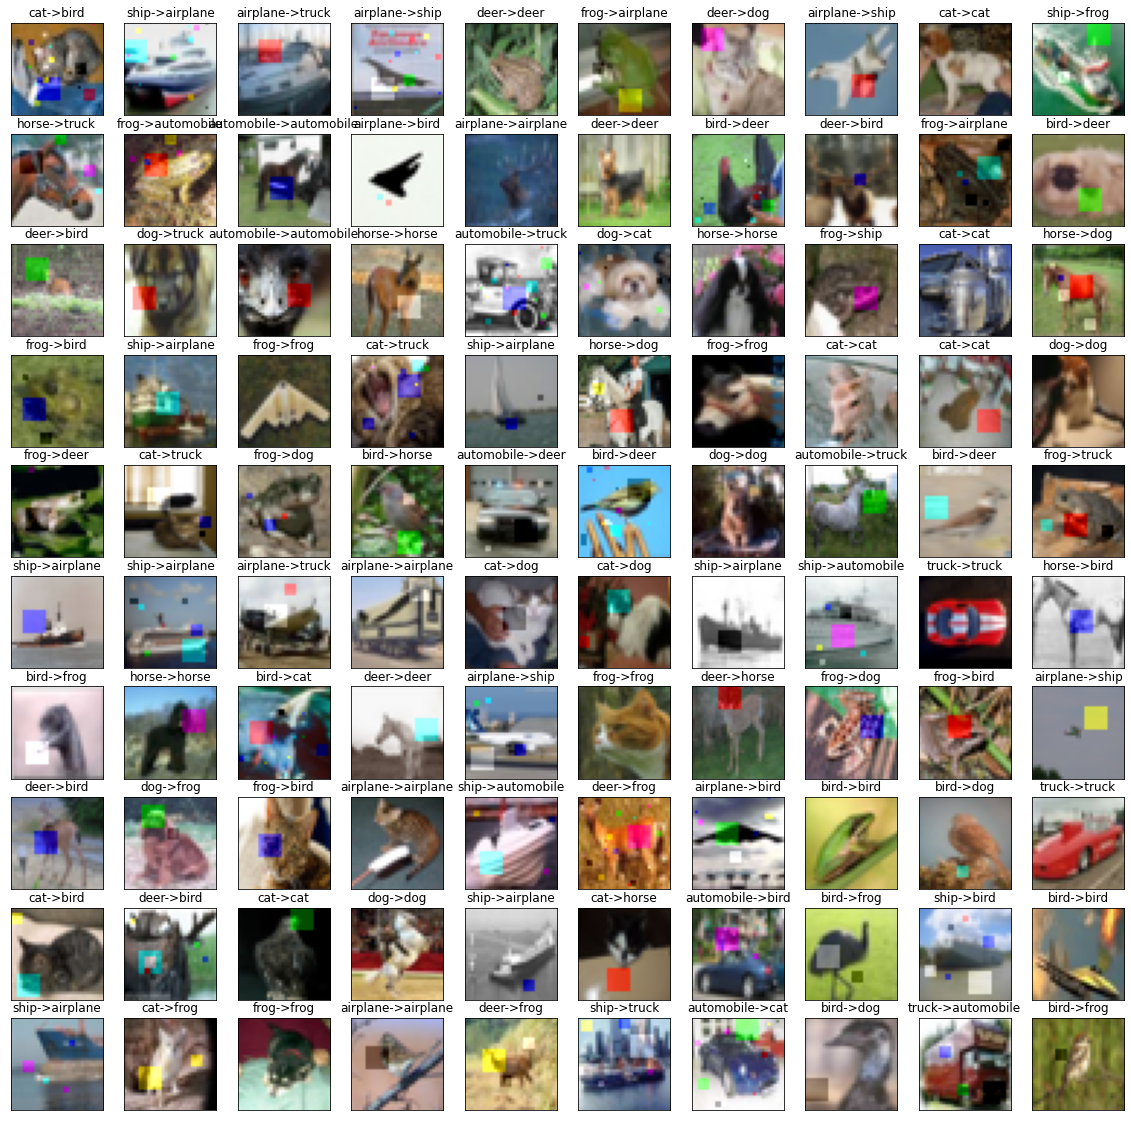

In [12]:
# CIFAR-10
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
adv_examples = adv_examples[:100]
plt.figure(figsize=(20, 20))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex  # Normalizing pixel values
    plt.title(f"{label_mapping[orig.item()]}->{label_mapping[adv.item()]}")
    plt.imshow(ex)

plt.show()
